# Basic Canonical Transformation

This example illustrates the basic application of a canonical transformation to a toy model Hamiltonian using the ``CanonicalTransformation`` class.

We start by importing numpy, sympy, and matplotlib along with ``celmech`` classes that we'll be using in this example.

In [1]:
import sympy as sp
import numpy as np
from matplotlib import pyplot as plt

from celmech import CanonicalTransformation, Hamiltonian, PhaseSpaceState

### Initializing a Hamiltonian

We construct an expression for our simple toy Hamiltonian from sympy variables below.
Our canonical coordinates and momenta will be $(q_1,q_2)$ and $(p_1,p_2)$, respectively.

In [2]:
p1,p2,q1,q2 = sp.symbols("p(1:3),q(1:3)")
H = p1**2/2 + p2 +  p2**4 + sp.cos(3*q1 + 2 * q2)
H

  2                              
p₁      4                        
─── + p₂  + p₂ + cos(3⋅q₁ + 2⋅q₂)
 2                               

To complete the construction of our Hamiltonian system, we initialize a ``PhaseSpaceState`` and generate a ``Hamiltonian`` object.

Note that our Hamiltonian doesn't have any free parameters so the ``H_params`` argument to our ``Hamiltonian`` constructor is simply an empty dictionary.

In [3]:
np.random.seed(1)
state=PhaseSpaceState([q1,q2,p1,p2],np.random.uniform(-0.5,0.5,4))
ham = Hamiltonian(H,{},state)

ham.H

  2                              
p₁      4                        
─── + p₂  + p₂ + cos(3⋅q₁ + 2⋅q₂)
 2                               

### Constructing a canonical transformation
Next, we'll build a canonical transformation to new variables $(Q_i,P_i)$  according to 
 $\mathbf{Q} = T\cdot \mathbf{q}$ 
 and
 $\mathbf{P} = (T^{-1})^\mathrm{T} \cdot \mathbf{p}$
 for a matrix $T$.
We'll construct our transformations so that $Q_1 = 3q_1+2q_2$, the argument of the cosine term appearing in the original Hamiltonian and we'll set $Q_2 = q_2$. 

We use the ``CanonicalTransformation`` class method ``from_linear_angle_transformation`` to produce a ``CanonicalTransformation`` instance representing the desired transformation:

In [4]:
Tmtrx = [[3,2],[0,1]]
qp_old = ham.qp_vars
ct = CanonicalTransformation.from_linear_angle_transformation(qp_old,Tmtrx)

We examine the resulting transformation by expressing each old canonical variable in terms of new variables and vice versa

In [5]:
for variable in ct.old_qp_vars:
    exprn = ct.old_to_new(variable)
    display((variable,exprn))

for variable in ct.new_qp_vars:
    exprn = ct.new_to_old(variable)
    display((variable,exprn))

⎛    Q₁   2⋅Q₂⎞
⎜q₁, ── - ────⎟
⎝    3     3  ⎠

(q₂, Q₂)

(p₁, 3⋅P₁)

(p₂, 2⋅P₁ + P₂)

(Q₁, 3⋅q₁ + 2⋅q₂)

(Q₂, q₂)

⎛    p₁⎞
⎜P₁, ──⎟
⎝    3 ⎠

⎛      2⋅p₁     ⎞
⎜P₂, - ──── + p₂⎟
⎝       3       ⎠

Now we'll use our canonical transformation to generate a new Hamiltonian

In [6]:
kam_full = ct.old_to_new_hamiltonian(ham)
kam_full.H

    2                                     
9⋅P₁                           4          
───── + 2⋅P₁ + P₂ + (2⋅P₁ + P₂)  + cos(Q₁)
  2                                       

After the transformation, the Hamiltonian does not depend on $Q_2$, so the corresponding momentum variable, $P_2$, is conserved.

### Reducing degree of freedom
We can elect to generate a new Hamiltonian in terms of the reduced phase space variables, $(Q_1,P_1)$ in which the conserved quantity $P_2$ appears as a parameter instead of a dynamical variable. 
This is done by passing the keyword argument ``do_reduction=True`` below:

In [7]:
kam_reduced = ct.old_to_new_hamiltonian(ham,do_reduction=True)

In [8]:
kam_reduced.H

    2                                     
9⋅P₁                           4          
───── + 2⋅P₁ + P₂ + (2⋅P₁ + P₂)  + cos(Q₁)
  2                                       

While the resulting symbolic expression for the Hamiltonian is the same, the canonical variables of ``kam_reduced`` are just $(Q_1,P_1)$ while variables $(Q_2,P_2)$ are now stored as parameters. This is evident when examining the ``N_H`` property of ``kam_reduced``:

In [9]:
print("canonical variables:",kam_reduced.qp_vars)
print("parameters:",kam_reduced.H_params)
kam_reduced.N_H

canonical variables: [Q1, P1]
parameters: {Q2: 0.2203244934421581, P2: 0.13558965608694318}


    2                                                                     
9⋅P₁                                       4                              
───── + 2⋅P₁ + 16⋅(P₁ + 0.0677948280434716)  + cos(Q₁) + 0.135589656086943
  2                                                                       

The reduced Hamiltonian still keeps track the full set of phase space variables, $(Q_1,Q_2,P_1,P_2)$, through the ``full_qp`` attribute. This stores a dictionary-like representation where the variable symbols serve as keys and their numerical values as the associated value entries.

In [10]:
dict(kam_reduced.full_qp)

{P₁: -0.1666285417275517, P₂: 0.13558965608694318, Q₁: 0.1917150009920382, Q₂:
 0.2203244934421581}

It is particularly useful to have access to these values in situations where one wishes to carry out an integration or other calculation in the reduced phase space reduced Hamiltonian, but express results in the original phase space variables using the inverse canonical transformation.
However, as we will see below, the numerical value stored for $Q_2$ in ``full_qp`` will **NOT** be updated according to $\frac{d}{dt}Q_2 = \frac{\partial}{\partial P_2}$ when the system is integrated forward in time.

### Integrating the equations of motion
We now integrate each of the three Hamiltonians, the original ``ham`` as well as ``kam_full`` and ``kam_reduced``.

In [11]:
N=100
times = np.linspace(0,10,N)
ham_results = np.zeros((N,ham.N_dim))
kam_full_results = np.zeros((N,kam_full.N_dim))
kam_reduced_results = np.zeros((N,kam_full.N_dim))
for i,t in enumerate(times):
    ham.integrate(t)
    kam_full.integrate(t)
    kam_reduced.integrate(t)
    ham_results[i] = ham.values
    kam_full_results[i] = kam_full.values
    kam_reduced_results[i] = kam_reduced.full_values

### Plotting results in terms of variables $(Q_1,Q_2,P_1,P_2)$:
- We make use of the ``old_to_new_array`` method to convert old variable values stored in ``ham_results`` to values of $(Q_1,Q_2,P_1,P_2)$.
- Note that the integration results derived from the reduced Hamiltonian do not correctly capture the evolution of the variable $Q_2$ but that the evolution of all other dynamical variables agree.

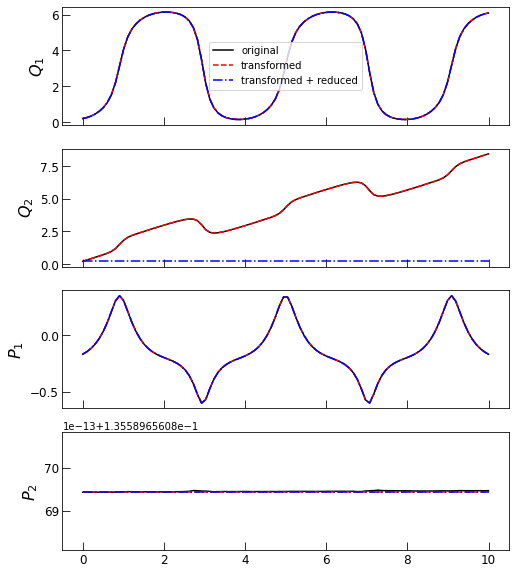

In [12]:
ham_results_tr = ct.old_to_new_array(ham_results.T).T
fig,ax = plt.subplots(4,1,sharex=True,figsize=(8,10))
for i,symb in enumerate(kam_full.qp_vars):
    for j,res in enumerate((ham_results,kam_full_results,kam_reduced_results)):
        style = ["k-","r--","b-."][j]
        lbl = ["original","transformed","transformed + reduced"][j]
        if j==0:
            y = ct.old_to_new_array(res.T)[i]
        else:
            y = res[:,i]
        ax[i].plot(times,y,style,label=lbl)
    ax[i].set_ylabel("$" + sp.latex(symb)+"$",fontsize=16)
    plt.sca(ax[i])
    plt.tick_params(labelsize=12,size=8,direction='in')
ax[0].legend()

### Plotting results in terms of variables  $(q_1,q_2,p_1,p_2)$:
- We make use of the ``new_to_old_array`` method to convert variable values stored in ``kam_full_results`` to and ``kam_reduced_results`` values of $(q_1,q_2,p_1,p_2)$.
- Note that, becase ``kam_reduced_results`` did not properly capture the evolution of $Q_2$, the resulting values of the angle variables $q_1$ and $q_2$ do not agree with the other integrations. Nonetheless, the evolution of the momentum variables, $p_1$ and $p_2$, is correctly reprodcued.

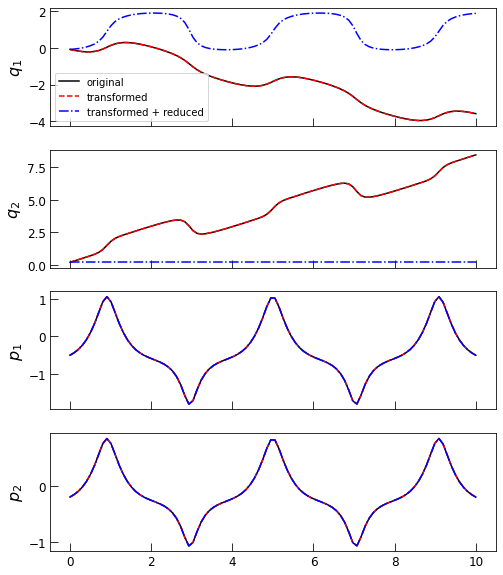

In [13]:
fig,ax = plt.subplots(4,1,sharex=True,figsize=(8,10))
for i,symb in enumerate(ham.qp_vars):
    for j,res in enumerate((ham_results,kam_full_results,kam_reduced_results)):
        style = ["k-","r--","b-."][j]
        lbl = ["original","transformed","transformed + reduced"][j]
        if j==0:
            y = res[:,i]
        else:
            y = ct.new_to_old_array(res.T)[i]
        ax[i].plot(times,y,style,label=lbl)
    ax[i].set_ylabel("$" + sp.latex(symb)+"$",fontsize=16)
    plt.sca(ax[i])
    plt.tick_params(labelsize=12,size=8,direction='in')
ax[0].legend()